# Elastica paper figures
In this notebook the figures from the paper [Keemink & van Rossum (2015) - etc.) are reproduced, and in the process it is shown how to use the elastica library and some general widgets. 

Necessary libraries:
- matplotlib
- scipy
- numpy
- HoloViews (http://holoviews.org/)

In [4]:
import holoviews as hv
%load_ext holoviews.ipython
%output widgets='embed' holomap='widgets' size=150 fig='png'
import elastica_neurons as en
import pylab    as pl
from   pylab import exp,cos,sin,pi,tan
import numpy as np

/home/sander/.virtualenvs/main/local/lib/python2.7/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


First, let's set the basic model parameters

In [5]:
Ac = 1     # basic tuning magnitude
Kc = 1   # basic tuning width (lower is wider)
a  = 0.1  # modulation strength
E0 = 4     # modulation offset
N  = 32    # number of neurons per location

Define basic plotting functions

In [6]:
def plotsceneandresponses(scene,iLoc):
    ''' plots the scene and the responses plus underlying drive and modulations for location iLoc
    Inputs
    -----------------
    - scene: the scene to plot
    - iLoc: bar position to plot responses and drives+modulations for
    
    Output
    ------------------
    - Holoviews object of the Figure
    '''
    # get the scene plot
    ScenePlot = scene.plotscene()

    # simulate the scene for location iLoc (i.e. the bar number), and assuming we're not on a torus
    scene.simulate(iLoc,torus='off')

    # get the preferred orientations
    pref        = scene.ang/pi

    # get the drive, modulation, and final response of iLoc
    centerdrive = hv.Curve(zip(pref,scene.FRc[iLoc,:]),label='center drive')
    surroundmod = hv.Curve(zip(pref,scene.FRs[iLoc,:]),label='flanker modulation')
    response    = hv.Curve(zip(pref,scene.FR[iLoc,:]),label='response')

    # make the response plot
    ResponsePlot = surroundmod*centerdrive*response

    # get the modulation contributions
    ModContributions = scene.plotlocalmod(iLoc,torus='off')

    # plot 
    return ScenePlot+ResponsePlot+ModContributions
    

### Example scenes
Setting up a few example scenes. 

3 bars

:Layout
   .Overlay.I   :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Curve.II  :Curve   [x]   (y)
      .Curve.III :Curve   [x]   (y)
      .Curve.IV  :Curve   [x]   (y)
   .Overlay.II  :Overlay
      .Curve.Flanker_modulation :Curve   [x]   (y)
      .Curve.Center_drive       :Curve   [x]   (y)
      .Curve.Response           :Curve   [x]   (y)
   .Overlay.III :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Curve.II  :Curve   [x]   (y)
      .Curve.III :Curve   [x]   (y)
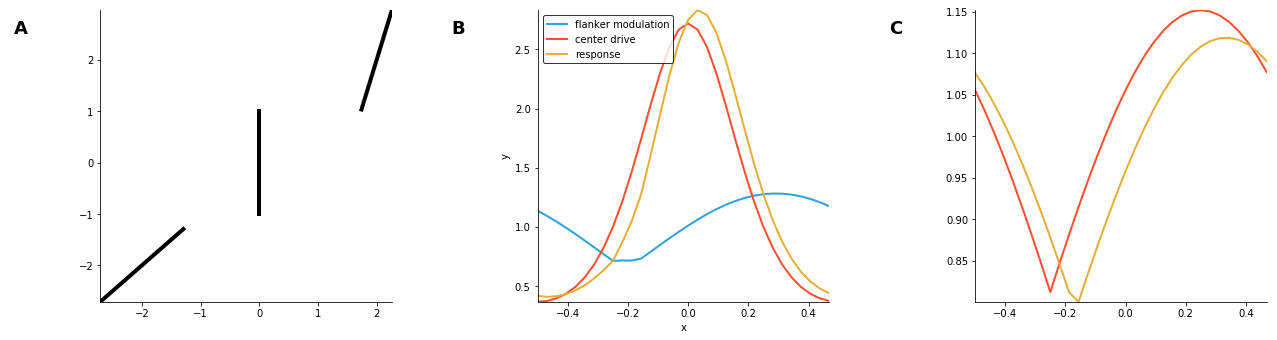

In [7]:
%%opts Curve {+axiswise} 
# above makes sure the normalization is done by axis, rather than across all of them

# set bar orientations
a1 = 0*pi/180 # bar 1 orientation
a2 = 45*pi/180 # bar 2 orientation
a3 = 15*pi/180 # bar 3 orientation
A  = pl.array([a1,a2,a3])

# set bar positions (x and y positions)
X = pl.array([[0,0],[-2,-2],[2,2]])

# Setup the scene
scene_3b = en.scene(N,A,X,[15,15],Kc,Ac,a,E0)

# plot
plotsceneandresponses(scene_3b,iLoc=0)

A center bar and n surround bars, with a center and surround orientation. The surround orientation rotates the entire surround.

:Layout
   .Overlay.I   :Overlay
      .Curve.I    :Curve   [x]   (y)
      .Curve.II   :Curve   [x]   (y)
      .Curve.III  :Curve   [x]   (y)
      .Curve.IV   :Curve   [x]   (y)
      .Curve.V    :Curve   [x]   (y)
      .Curve.VI   :Curve   [x]   (y)
      .Curve.VII  :Curve   [x]   (y)
      .Curve.VIII :Curve   [x]   (y)
   .Overlay.II  :Overlay
      .Curve.Flanker_modulation :Curve   [x]   (y)
      .Curve.Center_drive       :Curve   [x]   (y)
      .Curve.Response           :Curve   [x]   (y)
   .Overlay.III :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Curve.II  :Curve   [x]   (y)
      .Curve.III :Curve   [x]   (y)
      .Curve.IV  :Curve   [x]   (y)
      .Curve.V   :Curve   [x]   (y)
      .Curve.VI  :Curve   [x]   (y)
      .Curve.VII :Curve   [x]   (y)
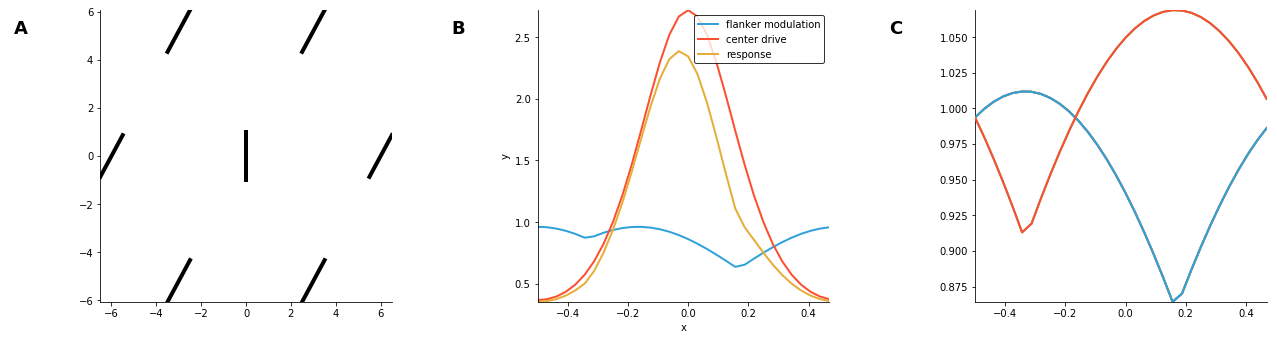

In [8]:
%%opts Curve {+axiswise} 
# above makes sure the normalization is done by axis, rather than across all of them
# set some scene parameters
ns = 6 # number of surround bars
R  = 6 # surround distance

# set bar orientations
c = 0*pi/180 # center bar orientation
s = 30*pi/180 # surround bars orientation
A  = pl.zeros(ns+1) # define all bars as having zero degree orientation
A[0] = c # sets first bar as center orientation
A[1:] = pl.ones(ns)*s # sets all other bars as surround orientation

# set bar positions (x and y positions)
X = pl.zeros((ns+1,2)) # set all bars positions to [0,0]
pos = pl.linspace(0,2*pi,ns+1)[:-1]+pi/2 # flanker angular positions (+ pi/2 to get the scene from figure 5F)
X[1:,0]= R*sin(pos) # sets x positions
X[1:,1]= R*cos(pos) # sets y positions
# (position of center is assumed to be [0,0])

# Setup the scene
scene_sur = en.scene(N,A,X,[15,15],Kc,Ac,a,E0,modtype='elastica')

# plot
plotsceneandresponses(scene_sur,iLoc=0)



Calculate the illusion for a given scene, for all flanker orientations

:Layout
   .Overlay.I :Overlay
      .Curve.I    :Curve   [x]   (y)
      .Curve.II   :Curve   [x]   (y)
      .Curve.III  :Curve   [x]   (y)
      .Curve.IV   :Curve   [x]   (y)
      .Curve.V    :Curve   [x]   (y)
      .Curve.VI   :Curve   [x]   (y)
      .Curve.VII  :Curve   [x]   (y)
      .Curve.VIII :Curve   [x]   (y)
      .Curve.IX   :Curve   [x]   (y)
      .Curve.X    :Curve   [x]   (y)
   .Curve.I   :Curve   [x]   (y)
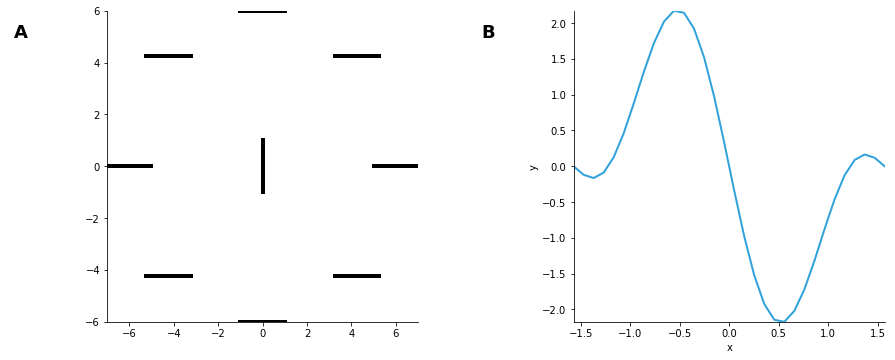

In [9]:
%%opts Curve {+axiswise} 
# above makes sure the normalization is done by axis, rather than across all of them

# set some scene parameters
ns = 8 # number of surround bars
R  = 6 # surround distance
nO = 32 # number of orientations to test
bias = pl.zeros(nO) # array to store decoding biases in

# set bar orientations
c = 0*pi/180 # center bar orientation
S = pl.linspace(-pi/2,pi/2,nO) # surround bars orientations
A  = pl.zeros(ns+1) # define all bars as having zero degree orientation
A[0] = c # sets first bar as center orientation

# set bar positions (x and y positions)
X = pl.zeros((ns+1,2)) # set all bars positions to [0,0]
pos = pl.linspace(0,2*pi,ns+1)[:-1]+pi/2 # flanker angular positions 
X[1:,0]= R*sin(pos) # sets x positions
X[1:,1]= R*cos(pos) # sets y positions

# set basic scene
scene = en.scene(N,A,X,[15,15],Kc,Ac,a,E0,modtype='elastica')

# loop over surround orientations
for i,s in enumerate(S):
    # reset positions
    pos = pl.linspace(0,2*pi,ns+1)[:-1]+pi/2+s # flanker angular positions , 
    #+s to make the entire surround rotate with surround orientation, remove that to keep bars in place (but still rotate)
    scene.X[1:,0]= R*sin(pos) # resets x positions flankers
    scene.X[1:,1]= R*cos(pos) # resets y positions flankers
    
    # set orientations 
    scene.O[1:] = s # sets all bars except center as surround orientation
    
    # simulate the neurons at the center location
    scene.simulate(0,torus='off')
    
    # get the encoded orientation of the center neuron
    bias[i] = scene.est[0]*180/pi

# plot the scene and biases
scene.plotscene()+hv.Curve(zip(S,bias))


Make a scene with a salient element

In [10]:
reload(en)

<module 'elastica_neurons' from 'elastica_neurons.pyc'>

In [11]:

def fixVScdep_plot(A,X,modtype='distance',saltype='max',group=None):
    # Setup the scene for fixed modulation
    scene_fix = en.scene(N,A,X,[X[:,0].max()+dist,X[:,1].max()+dist],Kc,Ac,a,E0,modtype=modtype)

    # simulate
    scene_fix.simulate_all()

    # calculate saliency
    scene_fix.saliency(saltype)

    # get saliencies and orientations
    sal_fix = scene_fix.sal
    or_fix = scene_fix.est

    # do above for cdep
    scene_cd = en.scene(N,A,X,[X[:,0].max()+dist,X[:,1].max()+dist],Kc,Ac,a,E0,modtype=modtype,surdep='cdep')
    scene_cd.simulate_all()
    scene_cd.saliency(saltype)
    sal_cdep = scene_cd.sal
    or_cdep = scene_cd.est

    # get maximum saliency
    sal_max = max([max(sal_fix),max(sal_cdep)])

    # plot
    figA = scene_cd.plotscene(length=dist/2) 
    figB= scene_fix.plotscene(length=dist/2,oriens=or_fix,alphas=sal_fix/sal_max)
    figC= scene_cd.plotscene(length=dist/2,oriens=or_cdep,alphas=sal_cdep/sal_max)
    if group == None:
        group_ = 'Stimulus'
    else:
        group_ = group
    figA.group = group_
    if group == None:
        group_ = 'Decoded \n (fixed modulation)'
    else:
        group_ = group
    figB.group = group_
    if group == None:
        group_ = 'Decoded \n (c-dep modulation)'
    else:
        group_ = group
    figC.group = group_
    # show plot
    return figA+figB+figC,scene_fix,scene_cd

def plot_frs(cell,scene):
    ang = scene.ang
    frc = scene.FRc[cell,:]
    frs = scene.FRs[cell,:]
    frf = scene.FR[cell,:]
    return hv.Curve(zip(ang,frs))*hv.Curve(zip(ang,frc))*hv.Curve(zip(ang,frf))

In [12]:
Kc = 0.6   # basic tuning width (lower is wider)
Ac = 20*exp(Kc)     # basic tuning magnitude
a  = 0.5    # modulation strength
E0 = 4     # modulation offset
N  = 32    # number of neurons per location

:Layout
   .Notit.I   :Overlay
      .Curve.I       :Curve   [x]   (y)
      .Curve.II      :Curve   [x]   (y)
      .Curve.III     :Curve   [x]   (y)
      .Curve.IV      :Curve   [x]   (y)
      .Curve.V       :Curve   [x]   (y)
      .Curve.VI      :Curve   [x]   (y)
      .Curve.VII     :Curve   [x]   (y)
      .Curve.VIII    :Curve   [x]   (y)
      .Curve.IX      :Curve   [x]   (y)
      .Curve.X       :Curve   [x]   (y)
      .Curve.XI      :Curve   [x]   (y)
      .Curve.XII     :Curve   [x]   (y)
      .Curve.XIII    :Curve   [x]   (y)
      .Curve.XIV     :Curve   [x]   (y)
      .Curve.XV      :Curve   [x]   (y)
      .Curve.XVI     :Curve   [x]   (y)
      .Curve.XVII    :Curve   [x]   (y)
      .Curve.XVIII   :Curve   [x]   (y)
      .Curve.XIX     :Curve   [x]   (y)
      .Curve.XX      :Curve   [x]   (y)
      .Curve.XXI     :Curve   [x]   (y)
      .Curve.XXII    :Curve   [x]   (y)
      .Curve.XXIII   :Curve   [x]   (y)
      .Curve.XXIV    :Curve   [x]   (y)
      .Curve.XXV     :Curve   [x]   (y)
      .Curve.XXVI    :Curve   [x]   (y)
      .Curve.XXVII   :Curve   [x]   (y)
      .Curve.XXVIII  :Curve   [x]   (y)
      .Curve.XXIX    :Curve   [x]   (y)
      .Curve.XXX     :Curve   [x]   (y)
      .Curve.XXXI    :Curve   [x]   (y)
      .Curve.XXXII   :Curve   [x]   (y)
      .Curve.XXXIII  :Curve   [x]   (y)
      .Curve.XXXIV   :Curve   [x]   (y)
      .Curve.XXXV    :Curve   [x]   (y)
      .Curve.XXXVI   :Curve   [x]   (y)
      .Curve.XXXVII  :Curve   [x]   (y)
      .Curve.XXXVIII :Curve   [x]   (y)
      .Curve.XXXIX   :Curve   [x]   (y)
      .Curve.XL      :Curve   [x]   (y)
      .Curve.XLI     :Curve   [x]   (y)
      .Curve.XLII    :Curve   [x]   (y)
      .Curve.XLIII   :Curve   [x]   (y)
      .Curve.XLIV    :Curve   [x]   (y)
      .Curve.XLV     :Curve   [x]   (y)
      .Curve.XLVI    :Curve   [x]   (y)
      .Curve.XLVII   :Curve   [x]   (y)
      .Curve.XLVIII  :Curve   [x]   (y)
      .Curve.XLIX    :Curve   [x]   (y)
      .Curve.L       :Curve   [x]   (y)
      .Curve.LI      :Curve   [x]   (y)
      .Curve.LII     :Curve   [x]   (y)
      .Curve.LIII    :Curve   [x]   (y)
      .Curve.LIV     :Curve   [x]   (y)
      .Curve.LV      :Curve   [x]   (y)
      .Curve.LVI     :Curve   [x]   (y)
      .Curve.LVII    :Curve   [x]   (y)
      .Curve.LVIII   :Curve   [x]   (y)
      .Curve.LIX     :Curve   [x]   (y)
      .Curve.LX      :Curve   [x]   (y)
      .Curve.LXI     :Curve   [x]   (y)
      .Curve.LXII    :Curve   [x]   (y)
      .Curve.LXIII   :Curve   [x]   (y)
      .Curve.LXIV    :Curve   [x]   (y)
      .Curve.LXV     :Curve   [x]   (y)
      .Curve.LXVI    :Curve   [x]   (y)
      .Curve.LXVII   :Curve   [x]   (y)
      .Curve.LXVIII  :Curve   [x]   (y)
      .Curve.LXIX    :Curve   [x]   (y)
      .Curve.LXX     :Curve   [x]   (y)
      .Curve.LXXI    :Curve   [x]   (y)
      .Curve.LXXII   :Curve   [x]   (y)
      .Curve.LXXIII  :Curve   [x]   (y)
      .Curve.LXXIV   :Curve   [x]   (y)
      .Curve.LXXV    :Curve   [x]   (y)
      .Curve.LXXVI   :Curve   [x]   (y)
      .Curve.LXXVII  :Curve   [x]   (y)
      .Curve.LXXVIII :Curve   [x]   (y)
      .Curve.LXXIX   :Curve   [x]   (y)
      .Curve.LXXX    :Curve   [x]   (y)
      .Curve.LXXXI   :Curve   [x]   (y)
      .Curve.LXXXII  :Curve   [x]   (y)
   .Notit.II  :Overlay
      .Curve.I       :Curve   [x]   (y)
      .Curve.II      :Curve   [x]   (y)
      .Curve.III     :Curve   [x]   (y)
      .Curve.IV      :Curve   [x]   (y)
      .Curve.V       :Curve   [x]   (y)
      .Curve.VI      :Curve   [x]   (y)
      .Curve.VII     :Curve   [x]   (y)
      .Curve.VIII    :Curve   [x]   (y)
      .Curve.IX      :Curve   [x]   (y)
      .Curve.X       :Curve   [x]   (y)
      .Curve.XI      :Curve   [x]   (y)
      .Curve.XII     :Curve   [x]   (y)
      .Curve.XIII    :Curve   [x]   (y)
      .Curve.XIV     :Curve   [x]   (y)
      .Curve.XV      :Curve   [x]   (y)
      .Curve.XVI     :Curve   [x]   (y)
      .Curve.XVII    :Curv
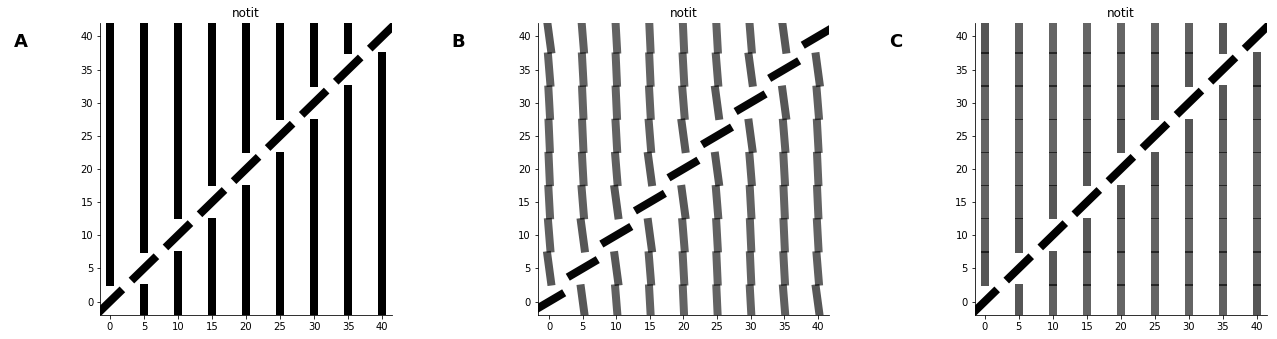

In [13]:
%%opts Curve {+axiswise} (linewidth=8)
# above makes sure the normalization is done by axis, rather than across all of them
# set some scene parameters
ns = 9 # width of height of scene in bars
dist = 5 # distance between bars

# set bar orientations
feat = 45*pi/180 # feature bar orientation
back = 0*pi/180 # background bars orientation
A  = pl.ones(ns*ns)*back # define all bars as having backgound degree orientation
feat_ids = [ns*(i)+(i) for i in range(ns)] # choose feature
A[feat_ids] = feat

# set bar positions (x and y positions)
X = pl.array([[x,y] for x in pl.arange(ns)*dist for y in pl.arange(ns)*dist]) # set all bars positions


fig_contour,scene_fix,scene_cd = fixVScdep_plot(A,X,group='notit')
fig_contour

:Layout
   .Stimulus.I                                                                 :Overlay
      .Curve.I       :Curve   [x]   (y)
      .Curve.II      :Curve   [x]   (y)
      .Curve.III     :Curve   [x]   (y)
      .Curve.IV      :Curve   [x]   (y)
      .Curve.V       :Curve   [x]   (y)
      .Curve.VI      :Curve   [x]   (y)
      .Curve.VII     :Curve   [x]   (y)
      .Curve.VIII    :Curve   [x]   (y)
      .Curve.IX      :Curve   [x]   (y)
      .Curve.X       :Curve   [x]   (y)
      .Curve.XI      :Curve   [x]   (y)
      .Curve.XII     :Curve   [x]   (y)
      .Curve.XIII    :Curve   [x]   (y)
      .Curve.XIV     :Curve   [x]   (y)
      .Curve.XV      :Curve   [x]   (y)
      .Curve.XVI     :Curve   [x]   (y)
      .Curve.XVII    :Curve   [x]   (y)
      .Curve.XVIII   :Curve   [x]   (y)
      .Curve.XIX     :Curve   [x]   (y)
      .Curve.XX      :Curve   [x]   (y)
      .Curve.XXI     :Curve   [x]   (y)
      .Curve.XXII    :Curve   [x]   (y)
      .Curve.XXIII   :Curve   [x]   (y)
      .Curve.XXIV    :Curve   [x]   (y)
      .Curve.XXV     :Curve   [x]   (y)
      .Curve.XXVI    :Curve   [x]   (y)
      .Curve.XXVII   :Curve   [x]   (y)
      .Curve.XXVIII  :Curve   [x]   (y)
      .Curve.XXIX    :Curve   [x]   (y)
      .Curve.XXX     :Curve   [x]   (y)
      .Curve.XXXI    :Curve   [x]   (y)
      .Curve.XXXII   :Curve   [x]   (y)
      .Curve.XXXIII  :Curve   [x]   (y)
      .Curve.XXXIV   :Curve   [x]   (y)
      .Curve.XXXV    :Curve   [x]   (y)
      .Curve.XXXVI   :Curve   [x]   (y)
      .Curve.XXXVII  :Curve   [x]   (y)
      .Curve.XXXVIII :Curve   [x]   (y)
      .Curve.XXXIX   :Curve   [x]   (y)
      .Curve.XL      :Curve   [x]   (y)
      .Curve.XLI     :Curve   [x]   (y)
      .Curve.XLII    :Curve   [x]   (y)
      .Curve.XLIII   :Curve   [x]   (y)
      .Curve.XLIV    :Curve   [x]   (y)
      .Curve.XLV     :Curve   [x]   (y)
      .Curve.XLVI    :Curve   [x]   (y)
      .Curve.XLVII   :Curve   [x]   (y)
      .Curve.XLVIII  :Curve   [x]   (y)
      .Curve.XLIX    :Curve   [x]   (y)
      .Curve.L       :Curve   [x]   (y)
      .Curve.LI      :Curve   [x]   (y)
      .Curve.LII     :Curve   [x]   (y)
      .Curve.LIII    :Curve   [x]   (y)
      .Curve.LIV     :Curve   [x]   (y)
      .Curve.LV      :Curve   [x]   (y)
      .Curve.LVI     :Curve   [x]   (y)
      .Curve.LVII    :Curve   [x]   (y)
      .Curve.LVIII   :Curve   [x]   (y)
      .Curve.LIX     :Curve   [x]   (y)
      .Curve.LX      :Curve   [x]   (y)
      .Curve.LXI     :Curve   [x]   (y)
      .Curve.LXII    :Curve   [x]   (y)
      .Curve.LXIII   :Curve   [x]   (y)
      .Curve.LXIV    :Curve   [x]   (y)
      .Curve.LXV     :Curve   [x]   (y)
      .Curve.LXVI    :Curve   [x]   (y)
      .Curve.LXVII   :Curve   [x]   (y)
      .Curve.LXVIII  :Curve   [x]   (y)
      .Curve.LXIX    :Curve   [x]   (y)
      .Curve.LXX     :Curve   [x]   (y)
      .Curve.LXXI    :Curve   [x]   (y)
      .Curve.LXXII   :Curve   [x]   (y)
      .Curve.LXXIII  :Curve   [x]   (y)
      .Curve.LXXIV   :Curve   [x]   (y)
      .Curve.LXXV    :Curve   [x]   (y)
      .Curve.LXXVI   :Curve   [x]   (y)
      .Curve.LXXVII  :Curve   [x]   (y)
      .Curve.LXXVIII :Curve   [x]   (y)
      .Curve.LXXIX   :Curve   [x]   (y)
      .Curve.LXXX    :Curve   [x]   (y)
      .Curve.LXXXI   :Curve   [x]   (y)
      .Curve.LXXXII  :Curve   [x]   (y)
   .Decoded_left_parenthesis_fixed_modulation_right_parenthesis.I              :Overlay
      .Curve.I       :Curve   [x]   (y)
      .Curve.II      :Curve   [x]   (y)
      .Curve.III     :Curve   [x]   (y)
      .Curve.IV      :Curve   [x]   (y)
      .Curve.V       :Curve   [x]   (y)
      .Curve.VI      :Curve   [x]   (y)
      .Curve.VII     :Curve   [x]   (y)
      .Curve.VIII    :Curve   [x]   (y)
      .Curve.IX      :Curve   [x]   (y)
      .Curve.X       :Curve   [x]   (y)
      .Curve.XI      :Curve   [x]   (y)
      .Curve.XII     :Curve   [x]   (y)
      .Curve.XIII    :Curve   [x]   (y)
      .Curve.XIV
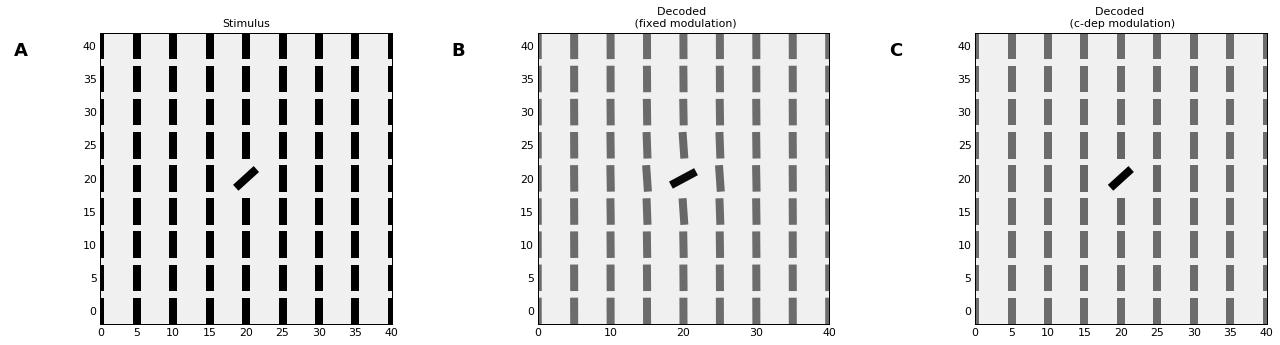

In [73]:
%%opts Curve {+axiswise} (linewidth=8)
# above makes sure the normalization is done by axis, rather than across all of them
# set some scene parameters
ns = 9 # width and height of scene in bars
dist = 5 # distance between bars

# set bar orientations
feat = 45*pi/180 # feature bar orientation
back = 0*pi/180 # background bars orientation
A  = pl.ones(ns*ns)*back # define all bars as having backgound degree orientation
feat_ids = ns*ns/2 # choose feature
A[feat_ids] = feat

# set bar positions (x and y positions)
X = pl.array([[x,y] for x in pl.arange(ns)*dist for y in pl.arange(ns)*dist]) # set all bars positions

# plot
fig_single,scene_fix,scene_cd  = fixVScdep_plot(A,X)
fig_single

:Layout
   .Notit.I   :Overlay
      .Curve.I       :Curve   [x]   (y)
      .Curve.II      :Curve   [x]   (y)
      .Curve.III     :Curve   [x]   (y)
      .Curve.IV      :Curve   [x]   (y)
      .Curve.V       :Curve   [x]   (y)
      .Curve.VI      :Curve   [x]   (y)
      .Curve.VII     :Curve   [x]   (y)
      .Curve.VIII    :Curve   [x]   (y)
      .Curve.IX      :Curve   [x]   (y)
      .Curve.X       :Curve   [x]   (y)
      .Curve.XI      :Curve   [x]   (y)
      .Curve.XII     :Curve   [x]   (y)
      .Curve.XIII    :Curve   [x]   (y)
      .Curve.XIV     :Curve   [x]   (y)
      .Curve.XV      :Curve   [x]   (y)
      .Curve.XVI     :Curve   [x]   (y)
      .Curve.XVII    :Curve   [x]   (y)
      .Curve.XVIII   :Curve   [x]   (y)
      .Curve.XIX     :Curve   [x]   (y)
      .Curve.XX      :Curve   [x]   (y)
      .Curve.XXI     :Curve   [x]   (y)
      .Curve.XXII    :Curve   [x]   (y)
      .Curve.XXIII   :Curve   [x]   (y)
      .Curve.XXIV    :Curve   [x]   (y)
      .Curve.XXV     :Curve   [x]   (y)
      .Curve.XXVI    :Curve   [x]   (y)
      .Curve.XXVII   :Curve   [x]   (y)
      .Curve.XXVIII  :Curve   [x]   (y)
      .Curve.XXIX    :Curve   [x]   (y)
      .Curve.XXX     :Curve   [x]   (y)
      .Curve.XXXI    :Curve   [x]   (y)
      .Curve.XXXII   :Curve   [x]   (y)
      .Curve.XXXIII  :Curve   [x]   (y)
      .Curve.XXXIV   :Curve   [x]   (y)
      .Curve.XXXV    :Curve   [x]   (y)
      .Curve.XXXVI   :Curve   [x]   (y)
      .Curve.XXXVII  :Curve   [x]   (y)
      .Curve.XXXVIII :Curve   [x]   (y)
      .Curve.XXXIX   :Curve   [x]   (y)
      .Curve.XL      :Curve   [x]   (y)
      .Curve.XLI     :Curve   [x]   (y)
      .Curve.XLII    :Curve   [x]   (y)
      .Curve.XLIII   :Curve   [x]   (y)
      .Curve.XLIV    :Curve   [x]   (y)
      .Curve.XLV     :Curve   [x]   (y)
      .Curve.XLVI    :Curve   [x]   (y)
      .Curve.XLVII   :Curve   [x]   (y)
      .Curve.XLVIII  :Curve   [x]   (y)
      .Curve.XLIX    :Curve   [x]   (y)
      .Curve.L       :Curve   [x]   (y)
      .Curve.LI      :Curve   [x]   (y)
      .Curve.LII     :Curve   [x]   (y)
      .Curve.LIII    :Curve   [x]   (y)
      .Curve.LIV     :Curve   [x]   (y)
      .Curve.LV      :Curve   [x]   (y)
      .Curve.LVI     :Curve   [x]   (y)
      .Curve.LVII    :Curve   [x]   (y)
      .Curve.LVIII   :Curve   [x]   (y)
      .Curve.LIX     :Curve   [x]   (y)
      .Curve.LX      :Curve   [x]   (y)
      .Curve.LXI     :Curve   [x]   (y)
      .Curve.LXII    :Curve   [x]   (y)
      .Curve.LXIII   :Curve   [x]   (y)
      .Curve.LXIV    :Curve   [x]   (y)
      .Curve.LXV     :Curve   [x]   (y)
      .Curve.LXVI    :Curve   [x]   (y)
      .Curve.LXVII   :Curve   [x]   (y)
      .Curve.LXVIII  :Curve   [x]   (y)
      .Curve.LXIX    :Curve   [x]   (y)
      .Curve.LXX     :Curve   [x]   (y)
      .Curve.LXXI    :Curve   [x]   (y)
      .Curve.LXXII   :Curve   [x]   (y)
      .Curve.LXXIII  :Curve   [x]   (y)
      .Curve.LXXIV   :Curve   [x]   (y)
      .Curve.LXXV    :Curve   [x]   (y)
      .Curve.LXXVI   :Curve   [x]   (y)
      .Curve.LXXVII  :Curve   [x]   (y)
      .Curve.LXXVIII :Curve   [x]   (y)
      .Curve.LXXIX   :Curve   [x]   (y)
      .Curve.LXXX    :Curve   [x]   (y)
      .Curve.LXXXI   :Curve   [x]   (y)
      .Curve.LXXXII  :Curve   [x]   (y)
   .Notit.II  :Overlay
      .Curve.I       :Curve   [x]   (y)
      .Curve.II      :Curve   [x]   (y)
      .Curve.III     :Curve   [x]   (y)
      .Curve.IV      :Curve   [x]   (y)
      .Curve.V       :Curve   [x]   (y)
      .Curve.VI      :Curve   [x]   (y)
      .Curve.VII     :Curve   [x]   (y)
      .Curve.VIII    :Curve   [x]   (y)
      .Curve.IX      :Curve   [x]   (y)
      .Curve.X       :Curve   [x]   (y)
      .Curve.XI      :Curve   [x]   (y)
      .Curve.XII     :Curve   [x]   (y)
      .Curve.XIII    :Curve   [x]   (y)
      .Curve.XIV     :Curve   [x]   (y)
      .Curve.XV      :Curve   [x]   (y)
      .Curve.XVI     :Curve   [x]   (y)
      .Curve.XVII    :Curv
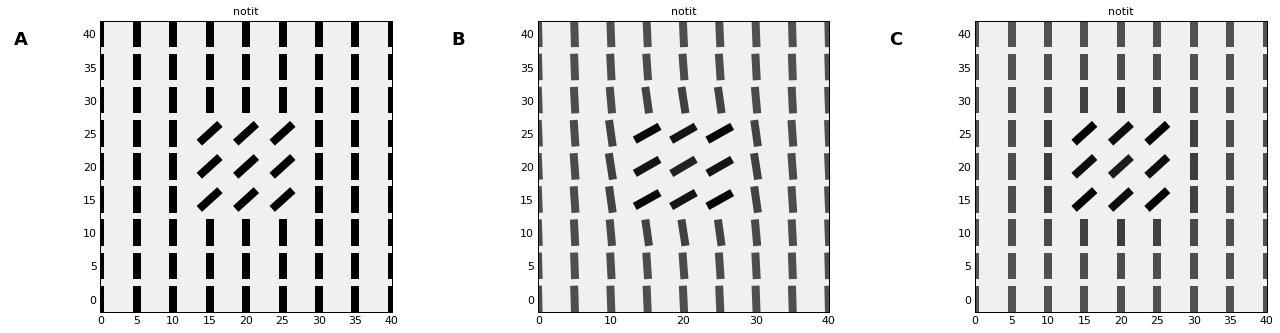

In [74]:
%%opts Curve {+axiswise} (linewidth=8)
# above makes sure the normalization is done by axis, rather than across all of them
# set some scene parameters
ns = 9 # width and height of scene in bars
dist = 5 # distance between bars

# set bar orientations
feat = 45*pi/180 # feature bar orientation
back = 0*pi/180 # background bars orientation
A  = pl.ones(ns*ns)*back # define all bars as having backgound degree orientation
feat_ids = ns*ns/2 # choose feature
feat_ids = [feat_ids-1-ns,feat_ids-ns,feat_ids+1-ns,feat_ids-1,feat_ids,feat_ids+1,
            feat_ids-1+ns,feat_ids+ns,feat_ids+1+ns]
A[feat_ids] = feat

# set bar positions (x and y positions)
X = pl.array([[x,y] for x in pl.arange(ns)*dist for y in pl.arange(ns)*dist]) # set all bars positions

# plot
fig_block,scene_fix,scene_cd = fixVScdep_plot(A,X,group='notit')
fig_block

In [75]:
figsss= hv.Image(scene_cd.FR.mean(axis=1).reshape(ns,ns).T)

:Layout
   .Notit.I   :Overlay
      .Curve.I         :Curve   [x]   (y)
      .Curve.II        :Curve   [x]   (y)
      .Curve.III       :Curve   [x]   (y)
      .Curve.IV        :Curve   [x]   (y)
      .Curve.V         :Curve   [x]   (y)
      .Curve.VI        :Curve   [x]   (y)
      .Curve.VII       :Curve   [x]   (y)
      .Curve.VIII      :Curve   [x]   (y)
      .Curve.IX        :Curve   [x]   (y)
      .Curve.X         :Curve   [x]   (y)
      .Curve.XI        :Curve   [x]   (y)
      .Curve.XII       :Curve   [x]   (y)
      .Curve.XIII      :Curve   [x]   (y)
      .Curve.XIV       :Curve   [x]   (y)
      .Curve.XV        :Curve   [x]   (y)
      .Curve.XVI       :Curve   [x]   (y)
      .Curve.XVII      :Curve   [x]   (y)
      .Curve.XVIII     :Curve   [x]   (y)
      .Curve.XIX       :Curve   [x]   (y)
      .Curve.XX        :Curve   [x]   (y)
      .Curve.XXI       :Curve   [x]   (y)
      .Curve.XXII      :Curve   [x]   (y)
      .Curve.XXIII     :Curve   [x]   (y)
      .Curve.XXIV      :Curve   [x]   (y)
      .Curve.XXV       :Curve   [x]   (y)
      .Curve.XXVI      :Curve   [x]   (y)
      .Curve.XXVII     :Curve   [x]   (y)
      .Curve.XXVIII    :Curve   [x]   (y)
      .Curve.XXIX      :Curve   [x]   (y)
      .Curve.XXX       :Curve   [x]   (y)
      .Curve.XXXI      :Curve   [x]   (y)
      .Curve.XXXII     :Curve   [x]   (y)
      .Curve.XXXIII    :Curve   [x]   (y)
      .Curve.XXXIV     :Curve   [x]   (y)
      .Curve.XXXV      :Curve   [x]   (y)
      .Curve.XXXVI     :Curve   [x]   (y)
      .Curve.XXXVII    :Curve   [x]   (y)
      .Curve.XXXVIII   :Curve   [x]   (y)
      .Curve.XXXIX     :Curve   [x]   (y)
      .Curve.XL        :Curve   [x]   (y)
      .Curve.XLI       :Curve   [x]   (y)
      .Curve.XLII      :Curve   [x]   (y)
      .Curve.XLIII     :Curve   [x]   (y)
      .Curve.XLIV      :Curve   [x]   (y)
      .Curve.XLV       :Curve   [x]   (y)
      .Curve.XLVI      :Curve   [x]   (y)
      .Curve.XLVII     :Curve   [x]   (y)
      .Curve.XLVIII    :Curve   [x]   (y)
      .Curve.XLIX      :Curve   [x]   (y)
      .Curve.L         :Curve   [x]   (y)
      .Curve.LI        :Curve   [x]   (y)
      .Curve.LII       :Curve   [x]   (y)
      .Curve.LIII      :Curve   [x]   (y)
      .Curve.LIV       :Curve   [x]   (y)
      .Curve.LV        :Curve   [x]   (y)
      .Curve.LVI       :Curve   [x]   (y)
      .Curve.LVII      :Curve   [x]   (y)
      .Curve.LVIII     :Curve   [x]   (y)
      .Curve.LIX       :Curve   [x]   (y)
      .Curve.LX        :Curve   [x]   (y)
      .Curve.LXI       :Curve   [x]   (y)
      .Curve.LXII      :Curve   [x]   (y)
      .Curve.LXIII     :Curve   [x]   (y)
      .Curve.LXIV      :Curve   [x]   (y)
      .Curve.LXV       :Curve   [x]   (y)
      .Curve.LXVI      :Curve   [x]   (y)
      .Curve.LXVII     :Curve   [x]   (y)
      .Curve.LXVIII    :Curve   [x]   (y)
      .Curve.LXIX      :Curve   [x]   (y)
      .Curve.LXX       :Curve   [x]   (y)
      .Curve.LXXI      :Curve   [x]   (y)
      .Curve.LXXII     :Curve   [x]   (y)
      .Curve.LXXIII    :Curve   [x]   (y)
      .Curve.LXXIV     :Curve   [x]   (y)
      .Curve.LXXV      :Curve   [x]   (y)
      .Curve.LXXVI     :Curve   [x]   (y)
      .Curve.LXXVII    :Curve   [x]   (y)
      .Curve.LXXVIII   :Curve   [x]   (y)
      .Curve.LXXIX     :Curve   [x]   (y)
      .Curve.LXXX      :Curve   [x]   (y)
      .Curve.LXXXI     :Curve   [x]   (y)
      .Curve.LXXXII    :Curve   [x]   (y)
      .Curve.LXXXIII   :Curve   [x]   (y)
      .Curve.LXXXIV    :Curve   [x]   (y)
      .Curve.LXXXV     :Curve   [x]   (y)
      .Curve.LXXXVI    :Curve   [x]   (y)
      .Curve.LXXXVII   :Curve   [x]   (y)
      .Curve.LXXXVIII  :Curve   [x]   (y)
      .Curve.LXXXIX    :Curve   [x]   (y)
      .Curve.XC        :Curve   [x]   (y)
      .Curve.XCI       :Curve   [x]   (y)
      .Curve.XCII      :Curve   [x]   (y)
      .Curve.XCIII     :Curve   [x]   (y)
      .Curve.XCIV      :Curve   [x]   (y)
      .Curve.XCV     
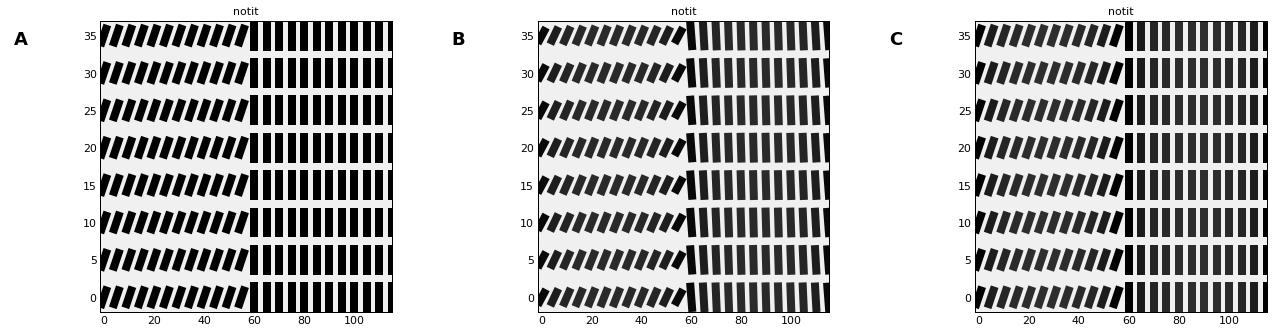

In [76]:
%%opts Curve {+axiswise} (linewidth=8)
# above makes sure the normalization is done by axis, rather than across all of them
# set some scene parameters
ny = 8 # height in bars
nx = ny*3 # width in bars
dist = 5 # distance between bars
# a = 0.05
# set bar orientations
feat = 0*pi/180 # feature bar orientation
back = 45*pi/180 # background bars orientation
A  = pl.ones(nx*ny)*back # define all bars as having backgound degree orientation
feat_ids = pl.arange(pl.floor(nx*ny/2),nx*ny,dtype=int)
A[feat_ids] = feat

# set bar positions (x and y positions)
X = pl.array([[x,y] for x in pl.arange(nx)*dist for y in pl.arange(ny)*dist]) # set all bars positions

# plot
fig_boundary,scene_fix,scene_cd = fixVScdep_plot(A,X,group='notit')
fig_boundary

:Image   [x,y]   (z)
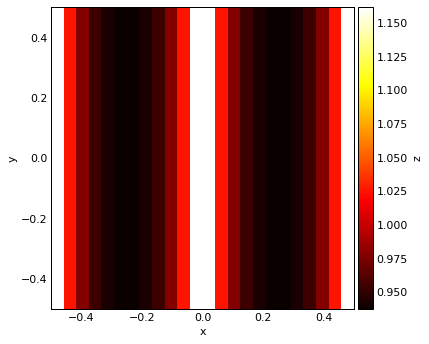

In [77]:
%%opts Image [colorbar=True]
hv.Image(scene_cd.sal.reshape(nx,ny).T)

In [78]:
scene_colors = scene_cd.FR

:Layout
   .Overlay.I   :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Curve.II  :Curve   [x]   (y)
      .Curve.III :Curve   [x]   (y)
   .Overlay.II  :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Curve.II  :Curve   [x]   (y)
      .Curve.III :Curve   [x]   (y)
   .Overlay.III :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Curve.II  :Curve   [x]   (y)
      .Curve.III :Curve   [x]   (y)
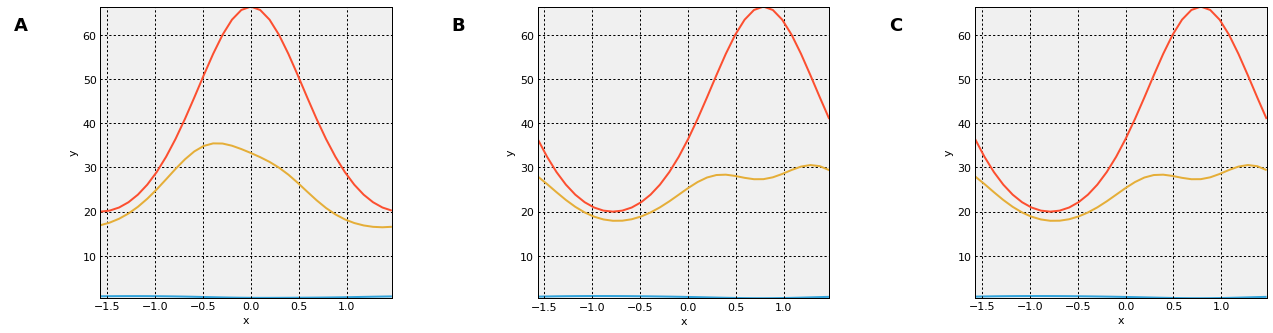

In [79]:
cell = ns*ns/2
plot_frs(ny*nx-1,scene_fix)+plot_frs(cell-ns,scene_fix)+plot_frs(ns*3,scene_fix)

:Layout
   .Stimulus.I                                                                 :Overlay
      .Curve.I       :Curve   [x]   (y)
      .Curve.II      :Curve   [x]   (y)
      .Curve.III     :Curve   [x]   (y)
      .Curve.IV      :Curve   [x]   (y)
      .Curve.V       :Curve   [x]   (y)
      .Curve.VI      :Curve   [x]   (y)
      .Curve.VII     :Curve   [x]   (y)
      .Curve.VIII    :Curve   [x]   (y)
      .Curve.IX      :Curve   [x]   (y)
      .Curve.X       :Curve   [x]   (y)
      .Curve.XI      :Curve   [x]   (y)
      .Curve.XII     :Curve   [x]   (y)
      .Curve.XIII    :Curve   [x]   (y)
      .Curve.XIV     :Curve   [x]   (y)
      .Curve.XV      :Curve   [x]   (y)
      .Curve.XVI     :Curve   [x]   (y)
      .Curve.XVII    :Curve   [x]   (y)
      .Curve.XVIII   :Curve   [x]   (y)
      .Curve.XIX     :Curve   [x]   (y)
      .Curve.XX      :Curve   [x]   (y)
      .Curve.XXI     :Curve   [x]   (y)
      .Curve.XXII    :Curve   [x]   (y)
      .Curve.XXIII   :Curve   [x]   (y)
      .Curve.XXIV    :Curve   [x]   (y)
      .Curve.XXV     :Curve   [x]   (y)
      .Curve.XXVI    :Curve   [x]   (y)
      .Curve.XXVII   :Curve   [x]   (y)
      .Curve.XXVIII  :Curve   [x]   (y)
      .Curve.XXIX    :Curve   [x]   (y)
      .Curve.XXX     :Curve   [x]   (y)
      .Curve.XXXI    :Curve   [x]   (y)
      .Curve.XXXII   :Curve   [x]   (y)
      .Curve.XXXIII  :Curve   [x]   (y)
      .Curve.XXXIV   :Curve   [x]   (y)
      .Curve.XXXV    :Curve   [x]   (y)
      .Curve.XXXVI   :Curve   [x]   (y)
      .Curve.XXXVII  :Curve   [x]   (y)
      .Curve.XXXVIII :Curve   [x]   (y)
      .Curve.XXXIX   :Curve   [x]   (y)
      .Curve.XL      :Curve   [x]   (y)
      .Curve.XLI     :Curve   [x]   (y)
      .Curve.XLII    :Curve   [x]   (y)
      .Curve.XLIII   :Curve   [x]   (y)
      .Curve.XLIV    :Curve   [x]   (y)
      .Curve.XLV     :Curve   [x]   (y)
      .Curve.XLVI    :Curve   [x]   (y)
      .Curve.XLVII   :Curve   [x]   (y)
      .Curve.XLVIII  :Curve   [x]   (y)
      .Curve.XLIX    :Curve   [x]   (y)
      .Curve.L       :Curve   [x]   (y)
      .Curve.LI      :Curve   [x]   (y)
      .Curve.LII     :Curve   [x]   (y)
      .Curve.LIII    :Curve   [x]   (y)
      .Curve.LIV     :Curve   [x]   (y)
      .Curve.LV      :Curve   [x]   (y)
      .Curve.LVI     :Curve   [x]   (y)
      .Curve.LVII    :Curve   [x]   (y)
      .Curve.LVIII   :Curve   [x]   (y)
      .Curve.LIX     :Curve   [x]   (y)
      .Curve.LX      :Curve   [x]   (y)
      .Curve.LXI     :Curve   [x]   (y)
      .Curve.LXII    :Curve   [x]   (y)
      .Curve.LXIII   :Curve   [x]   (y)
      .Curve.LXIV    :Curve   [x]   (y)
      .Curve.LXV     :Curve   [x]   (y)
      .Curve.LXVI    :Curve   [x]   (y)
      .Curve.LXVII   :Curve   [x]   (y)
      .Curve.LXVIII  :Curve   [x]   (y)
      .Curve.LXIX    :Curve   [x]   (y)
      .Curve.LXX     :Curve   [x]   (y)
      .Curve.LXXI    :Curve   [x]   (y)
      .Curve.LXXII   :Curve   [x]   (y)
      .Curve.LXXIII  :Curve   [x]   (y)
      .Curve.LXXIV   :Curve   [x]   (y)
      .Curve.LXXV    :Curve   [x]   (y)
      .Curve.LXXVI   :Curve   [x]   (y)
      .Curve.LXXVII  :Curve   [x]   (y)
      .Curve.LXXVIII :Curve   [x]   (y)
      .Curve.LXXIX   :Curve   [x]   (y)
      .Curve.LXXX    :Curve   [x]   (y)
      .Curve.LXXXI   :Curve   [x]   (y)
      .Curve.LXXXII  :Curve   [x]   (y)
   .Decoded_left_parenthesis_fixed_modulation_right_parenthesis.I              :Overlay
      .Curve.I       :Curve   [x]   (y)
      .Curve.II      :Curve   [x]   (y)
      .Curve.III     :Curve   [x]   (y)
      .Curve.IV      :Curve   [x]   (y)
      .Curve.V       :Curve   [x]   (y)
      .Curve.VI      :Curve   [x]   (y)
      .Curve.VII     :Curve   [x]   (y)
      .Curve.VIII    :Curve   [x]   (y)
      .Curve.IX      :Curve   [x]   (y)
      .Curve.X       :Curve   [x]   (y)
      .Curve.XI      :Curve   [x]   (y)
      .Curve.XII     :Curve   [x]   (y)
      .Curve.XIII    :Curve   [x]   (y)
      .Curve.XIV
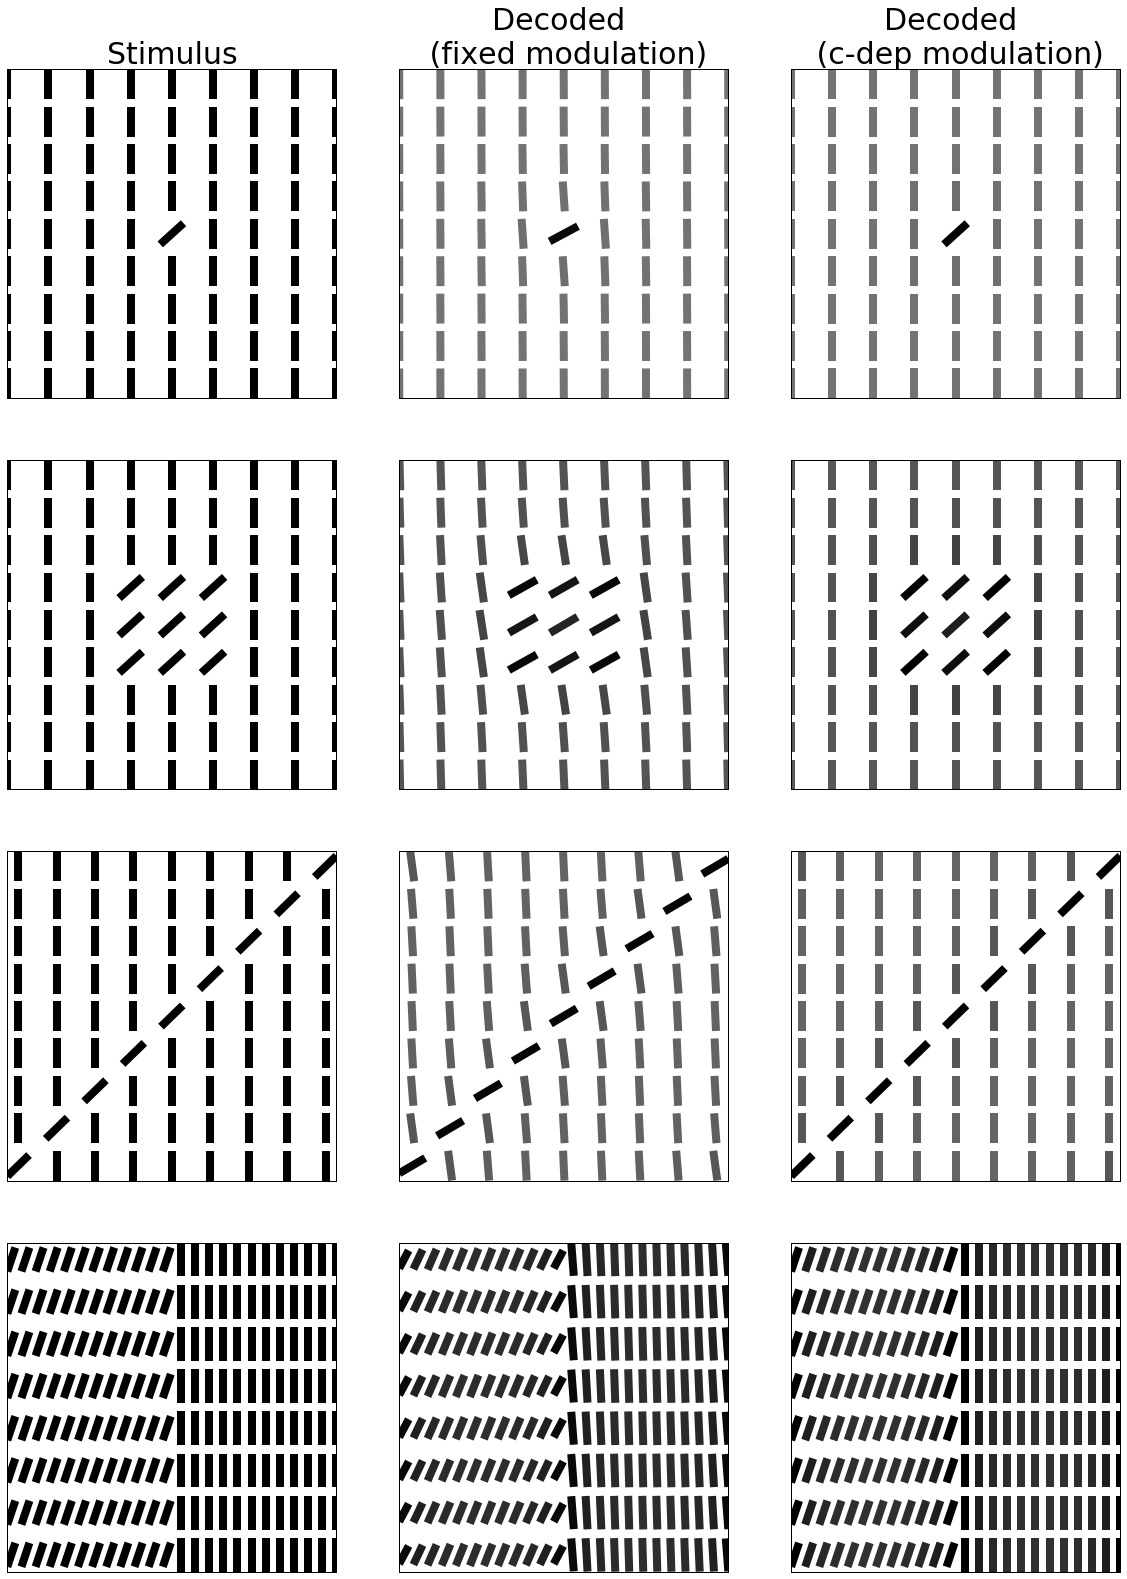

In [80]:
%%opts Layout [sublabel_format=None tight=True]
%%opts Overlay.notit [show_title=False]
%%opts Overlay [fontsize={'title':30}  show_frame=True xaxis='bottom-bare' yaxis='left-bare' bgcolor='white']
fig = fig_single+ fig_block + fig_contour + fig_boundary
fig.cols(3)

In [ ]:
np.mean

In [30]:
def plot_sal_curve(dist, ref, As, As_x, X, saltype, modtype='distance'):
    sal_cdep = np.zeros_like(As_x)
    sal_fix = np.zeros_like(As_x)
    
    for i, A in enumerate(As):
        # simulate fixed, and cdep, to get max saliency
        scene_sur = en.scene(N,A,X,[X[:,0].max()+dist,X[:,1].max()+dist],Kc,Ac,a,E0,modtype=modtype,surdep='fixed')
        scene_sur.simulate_all(torus='on')
        scene_sur.saliency(saltype)
        sal_fix[i] = scene_sur.sal[ref]
        scene_sur = en.scene(N,A,X,[X[:,0].max()+dist,X[:,1].max()+dist],Kc,Ac,a,E0,modtype=modtype,surdep='cdep')
        scene_sur.simulate_all(torus='on')
        scene_sur.saliency(saltype)
        sal_cdep[i] = scene_sur.sal[ref]

    fig = hv.Curve(zip(As_x, sal_cdep))(style={'color':'k', 'linestyle':'--'})
    fig *= hv.Curve(zip(As_x, sal_fix))(style={'color':'k'})

    return fig



Single bar

In [34]:
%%opts Curve {+axiswise} (linewidth=2 ) Overlay [xticks=3 yticks=3 aspect=3]
%%output fig='svg' size=300
# set some scene parameters
ns = 7 # width of height of scene in bars
dist = 5.0 # distance between bars
a = 0.1
# specify saliency type
saltype = 'mean'

# set bar orientations
feats = np.linspace(0,90,20)*pi/180 # feature bar orientations
back = 0*pi/180 # background bars orientation
As  = [np.ones(ns*ns)*back for feat in feats] # define all bars as having backgound degree orientation
feat_ids = ns*ns/2 # choose feature
for i in range(len(feats)):
    As[i][feat_ids] = feats[i]

# set bar positions (x and y positions)
X = np.array([[x,y] for x in np.arange(ns)*dist for y in np.arange(ns)*dist]) # set all bars positions

fig_single = plot_sal_curve(dist, feat_ids, As, feats/pi*180, X, saltype)
fig_single

:Overlay
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)

Outline

In [37]:
%%opts Curve {+axiswise} (linewidth=8)
# above makes sure the normalization is done by axis, rather than across all of them
# set some scene parameters
ns = 9 # width of height of scene in bars
dist = 5 # distance between bars

# set bar orientations
feats = np.linspace(0,90,10)*pi/180 # feature bar orientations
back = 0*pi/180 # background bars orientation
As  = [np.ones(ns*ns)*back for feat in feats] # define all bars as having backgound degree orientation
feat_ids = [ns*(i)+(i) for i in range(ns)] # choose feature
for i in range(len(feats)):
    As[i][feat_ids] = feats[i]
# set bar positions (x and y positions)
X = pl.array([[x,y] for x in pl.arange(ns)*dist for y in pl.arange(ns)*dist]) # set all bars positions

fig_single = plot_sal_curve(dist, feat_ids, As, feats/pi*180, X, saltype)
fig_single

ValueError: setting an array element with a sequence.